# STL File Import

This notebook will give a tutorial on importing and working with `.stl` surface mesh files in Tidy3d.

To use this functionality, remember to install Tidy3D as `pip install "tidy3d[trimesh]"`, which will install optional dependencies needed for processing surface meshes.

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3d imports
import tidy3d as td
import tidy3d.web as web

[16:29:23] WARNING: This version of Tidy3D was pip installed from the 'tidy3d-beta' ]8;id=944754;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=788959;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           repository on PyPI. Future releases will be uploaded to the 'tidy3d'              
           repository. From now on, please use 'pip install tidy3d' instead.                 

           INFO: Using client version: 1.10.0                                       ]8;id=687221;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=797944;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

## Getting started: a simple box mesh
We'll start with importing an STL file representing a simple slab. We need to make sure we understand the units associated with the data in the STL file. Here, we'll assume the STL data is stored in microns.

As a reference case, we'll also make a box with the same dimensions using the standard Tidy3D approach of making shapes: using [td.Box](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Box.html).

The STL box has size `0.8 um x 1.3 um x 0.3 um`.

In [2]:
# make the geometry object representing the STL solid from the STL file stored on disk
box = td.TriangleMesh.from_stl(
    filename="./misc/box.stl",
    scale=1, # the units are already microns as desired, but this parameter can be used to change units [default: 1]
    origin=(0, 0, 0), # this can be used to set a custom origin for the stl solid [default: (0, 0, 0)]
    solid_index=None, # sometimes, there may be more than one solid in the file; use this to select a specific one by index
)

# define material properties of the box
medium = td.Medium(permittivity=2)

# create a structure composed of the geometry and the medium
structure = td.Structure(geometry=box, medium=medium)

# to make sure the simulation runs correctly, let's also make a reference box the usual way
box_ref = td.Box(center=(0, 0, 0), size=(0.8, 1.3, 0.3))

# make the reference structure
structure_ref = td.Structure(geometry=box_ref, medium=medium)

wavelength = 0.3
f0 = td.C_0 / wavelength / np.sqrt(medium.permittivity)

# set the domain size in x, y, and z
domain_size = 2.5

# construct simulation size array
sim_size = (domain_size, domain_size, domain_size)

# Bandwidth in Hz
fwidth = f0 / 40.0

# Gaussian source offset; the source peak is at time t = offset/fwidth
offset = 4.0

# time dependence of sources
source_time = td.GaussianPulse(freq0=f0, fwidth=fwidth, offset=offset)

# Simulation run time past the source decay (around t=2*offset/fwidth)
run_time = 40 / fwidth


## Create sources and monitors
To study the effect of the various boundary conditions, we'll define a plane wave source and a set of frequency-domain monitors in the volume of the simulation domain.

In [3]:
# create a plane wave source
source = td.PlaneWave(
    center=(0, 0, -1),
    source_time=source_time,
    size=(td.inf, td.inf, 0),
    direction='+',
)

# these monitors will be used to plot fields on planes through the middle of the domain in the frequency domain
monitor_xz = td.FieldMonitor(
    center=(0, 0, 0), size=(domain_size, 0, domain_size), freqs=[f0], name="xz"
)
monitor_yz = td.FieldMonitor(
    center=(0, 0, 0), size=(0, domain_size, domain_size), freqs=[f0], name="yz"
)
monitor_xy = td.FieldMonitor(
    center=(0, 0, 0), size=(domain_size, domain_size, 0), freqs=[f0], name="xy"
)

## Create the simulation objects
We'll make two simulation objects: one for the STL box, and the other for the Tidy3D box, in order to compare the fields later on.

           INFO: Auto meshing using wavelength 0.4243 defined from sources.         ]8;id=188273;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=343504;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: Auto meshing using wavelength 0.4243 defined from sources.         ]8;id=696614;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=323893;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

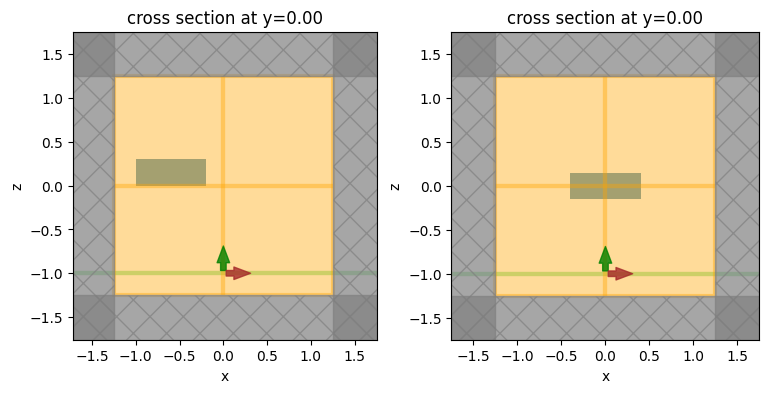

In [4]:
# STL simulation
sim = td.Simulation(
    size=sim_size,
    sources=[source],
    structures=[structure],
    monitors=[monitor_xz, monitor_yz, monitor_xy],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(td.PML()),
)

# reference simulation
sim_ref = td.Simulation(
    size=sim_size,
    sources=[source],
    structures=[structure_ref],
    monitors=[monitor_xz, monitor_yz, monitor_xy],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(td.PML()),
)

# plot both simulations to make sure everything is set up correctly
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
sim.plot(y=0, ax=ax1)
sim_ref.plot(y=0, ax=ax2)
plt.show();

We immediately notice a problem: the boxes are not centered in the same way! The reason is that we have not taken into account the definition of the origin in the STL file. In our Tidy3D box, the box's center coincides with `(0, 0, 0)`. However, in the STL file, the (min, min, min) corner of the box happens to have coordinates `(-1, -0.3, 0)`. We need to use the `origin` argument of `from_stl` to take this into account, so that STL box is centered on the simulation's origin.

Note that information regarding the STL file units and origin should be known by the user beforehand - it should be readily available in most CAD tools used for generating and manipulating STL files.

           INFO: Auto meshing using wavelength 0.4243 defined from sources.         ]8;id=643600;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=694987;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

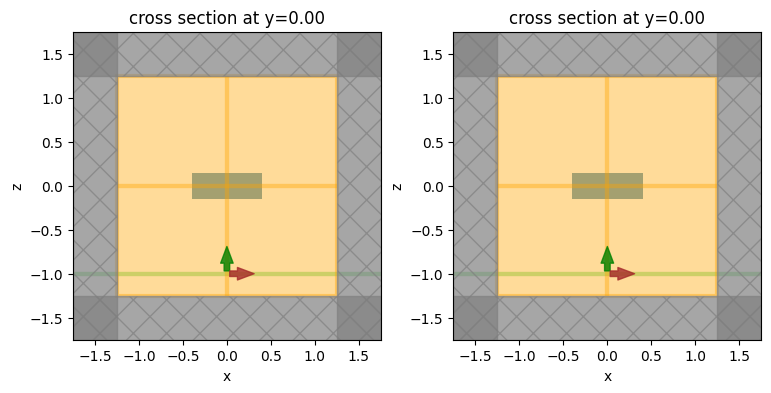

In [5]:
# in the STL's coordinate system, the box's center along each dim is (local_origin[dim] + size[dim] / 2)
# so in Tidy3D's coordinate system, we need and offset that is the negative of the above
box = td.TriangleMesh.from_stl(
    filename="./misc/box.stl",
    origin=(-(-1 + 0.4), -(-0.3 + 0.65), -(0 + 0.15)),
)

# create the structure with the updated box
structure = td.Structure(geometry=box, medium=medium)

# update the simulation object with the new structure
sim = sim.copy(update={"structures": [structure]})

# plot both simulations again
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
sim.plot(y=0, ax=ax1)
sim_ref.plot(y=0, ax=ax2)
plt.show();

This looks much better!

To make sure that the STL geometry is correctly parsed and processed by the solver, we can add a [PermittivityMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.PermittivityMonitor.html) to the simulation to plot the permittivity profile as seen by the solver. One could also use `sim.plot_eps()`, but the [PermittivityMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.PermittivityMonitor.html) will take into account the use of subpixel averaging at the edges of the solid, where applicable.

In [6]:
monitor_eps_xz = td.PermittivityMonitor(
    center=(0, 0, 0), size=(domain_size, 0, domain_size), freqs=[f0], name="xz_eps"
)

# update the simulation objects to add in the new monitor
sim = sim.copy(update={"monitors": list(sim.monitors) + [monitor_eps_xz]})
sim_ref = sim_ref.copy(update={"monitors": list(sim_ref.monitors) + [monitor_eps_xz]})

[16:29:24] INFO: Auto meshing using wavelength 0.4243 defined from sources.         ]8;id=812258;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=634135;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: Auto meshing using wavelength 0.4243 defined from sources.         ]8;id=616531;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=812556;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

## Run Simulations
We can now run both simulations and make sure the results match.

In [7]:
# STL simulation
sim_data = web.run(sim, task_name="stl_box", path="data/stl_box.hdf5")

# reference simulation
sim_data_ref = web.run(sim_ref, task_name="stl_box_ref", path="data/stl_box_ref.hdf5")

           INFO: Created task 'stl_box' with task_id                                ]8;id=687096;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=938541;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           'fdve-82e55fe1-b92d-4387-a0ea-4874a7a10dbev1'.                                    

Output()

Output()

[16:29:29] INFO: status = queued                                                    ]8;id=714067;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=671962;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:29:34] INFO: status = preprocess                                                ]8;id=573207;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=965527;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

[16:29:38] INFO: Maximum FlexUnit cost: 0.025. Use 'web.real_cost(task_id)' to get  ]8;id=56321;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=682994;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           the billed FlexUnit cost after a simulation run.                                  

           INFO: starting up solver                                                 ]8;id=201621;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=148750;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: running solver                                                     ]8;id=891984;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=499952;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:29:45] INFO: early shutoff detected, exiting.                                   ]8;id=493373;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=163179;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: status = postprocess                                               ]8;id=180837;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=849924;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:29:52] INFO: status = success                                                   ]8;id=672188;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=144084;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

           INFO: loading SimulationData from data/stl_box.hdf5                      ]8;id=133950;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=992068;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

[16:29:53] INFO: Auto meshing using wavelength 0.4243 defined from sources.         ]8;id=623432;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=787788;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: Created task 'stl_box_ref' with task_id                            ]8;id=692706;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=770826;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           'fdve-ad484dcf-c373-4f2c-b5e7-4e9258b68549v1'.                                    

Output()

           INFO: status = queued                                                    ]8;id=566225;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=726904;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:29:55] INFO: status = preprocess                                                ]8;id=594685;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=486922;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

[16:29:59] INFO: Maximum FlexUnit cost: 0.025. Use 'web.real_cost(task_id)' to get  ]8;id=695566;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=24211;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           the billed FlexUnit cost after a simulation run.                                  

           INFO: starting up solver                                                 ]8;id=631494;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=962702;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: running solver                                                     ]8;id=104769;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=156258;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:30:06] INFO: early shutoff detected, exiting.                                   ]8;id=18939;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=97537;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: status = postprocess                                               ]8;id=254815;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=409833;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:30:10] INFO: status = success                                                   ]8;id=187804;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=280998;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

           INFO: loading SimulationData from data/stl_box_ref.hdf5                  ]8;id=496567;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=816416;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

[16:30:11] INFO: Auto meshing using wavelength 0.4243 defined from sources.         ]8;id=679102;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=485290;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

## Visualize and compare
First, for both simulation objects, let's plot the permittivity data recorded by the [PermittivityMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.PermittivityMonitor.html).

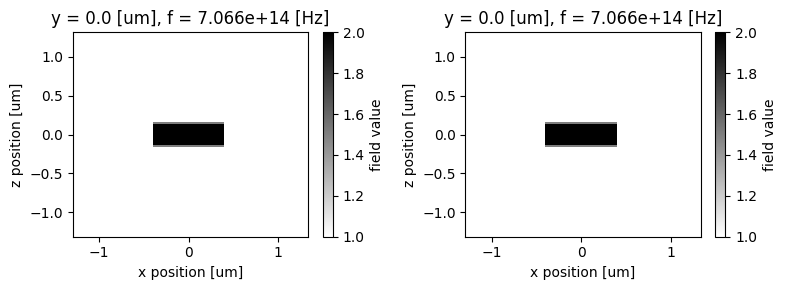

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 3))
sim_data["xz_eps"].eps_xx.real.plot(x='x', y='z', ax=ax1, cmap='binary')
sim_data_ref["xz_eps"].eps_xx.real.plot(x='x', y='z', ax=ax2, cmap='binary')
plt.show();

First, the permittivity profiles look identical in the two cases, which reassures us that the STL geometry is equivalent to the one natively built with Tidy3D. Second, we see the effects of subpixel averaging at the edges of the box in the vertical direction. This means that the top and bottom edges of the box lie partway through an FDTD cell, so an average of the box and background permittivities is used for those cells.

Next, we can plot the frequency-domain fields for both simulations and make sure they match.

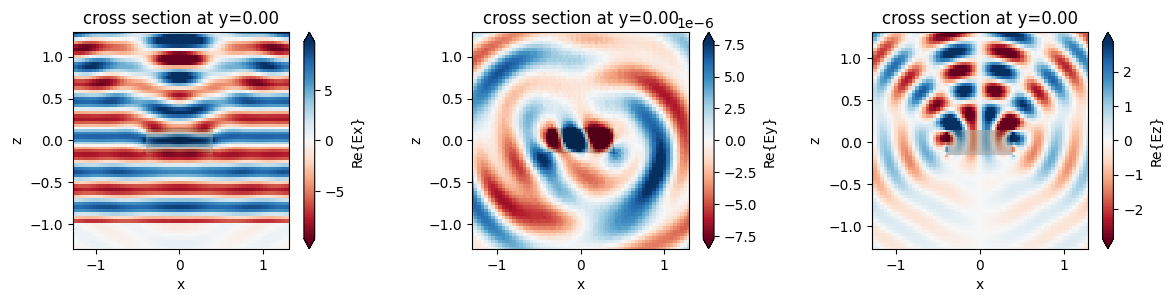

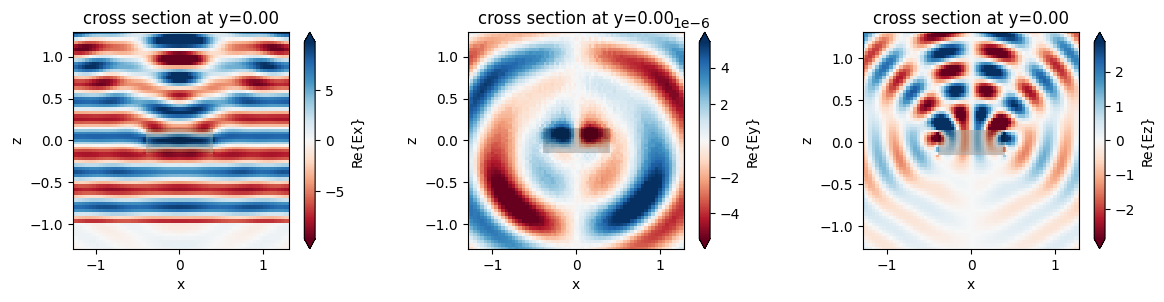

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3))
sim_data.plot_field(field_monitor_name="xz", field_name="Ex", y=0, val="real", ax=ax1)
sim_data.plot_field(field_monitor_name="xz", field_name="Ey", y=0, val="real", ax=ax2)
sim_data.plot_field(field_monitor_name="xz", field_name="Ez", y=0, val="real", ax=ax3)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3))
sim_data_ref.plot_field(field_monitor_name="xz", field_name="Ex", y=0, val="real", ax=ax1)
sim_data_ref.plot_field(field_monitor_name="xz", field_name="Ey", y=0, val="real", ax=ax2)
sim_data_ref.plot_field(field_monitor_name="xz", field_name="Ez", y=0, val="real", ax=ax3)
plt.show();


As expected, the fields look identical.

## Multiple STL solids and multiple files
Next, we'll demonstrate how multiple STL models can be imported into the same simulation. Also, we demonstrate the case when the same STL file contains more than one disjoint object.

We'll consider slightly more complicated geometries here, such as a box with a hole, and a box with a concave surface in the form of an indent. Our STL import and preprocessing functionality can handle all of these cases.

Note that:
- if the same STL file contains multiple disjoint objects stored as a single STL solid, it is assumed that those objects will all have the same material properties, because they are treated as a single Tidy3D [Geometry](https://docs.flexcompute.com/projects/tidy3d/en/latest/api.html#geometry);
- if the STL contains multiple objects stored as different STL solids, then each solid can be imported individually by index using the `solid_index` argument to `td.TriangleMesh.from_stl`, in which case different material properties can be assigned to different STL solids.

Here are 3D plots of the different STL objects we'll consider:

<img src="img/box_with_hole.png" width=199> <img src="img/box_with_indent.png" width=200> <img src="img/two_boxes.png" width=222>

[16:30:14] INFO: Auto meshing using wavelength 0.4243 defined from sources.         ]8;id=304277;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=319572;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

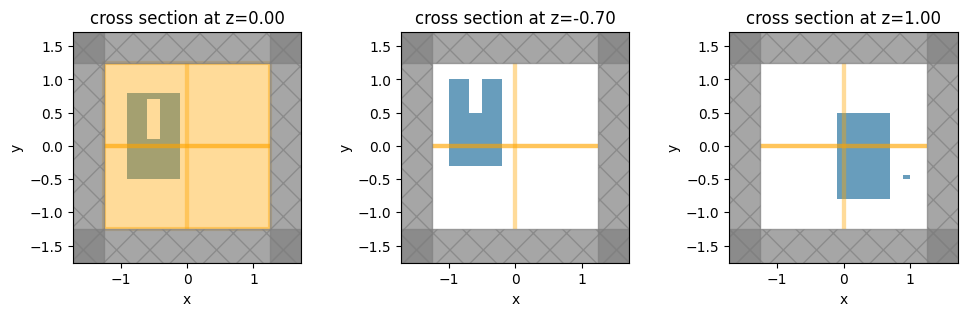

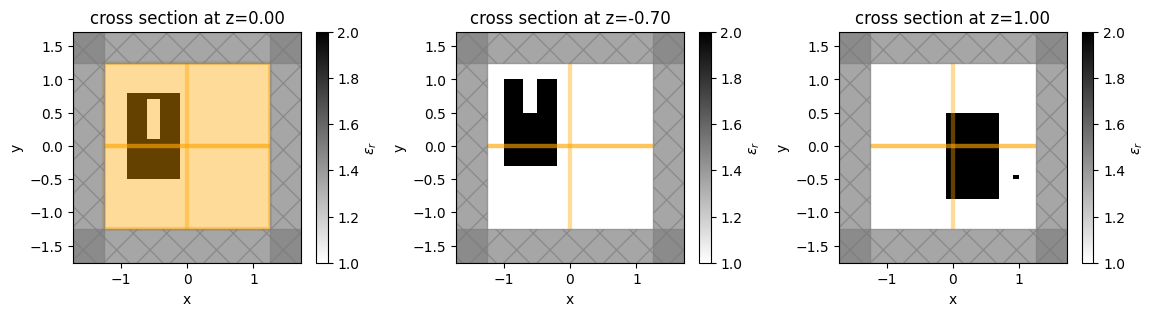

In [10]:
objs = [None] * 3

# first object: a box with a hole
objs[0] = td.TriangleMesh.from_stl(
    filename="./misc/box_with_hole.stl",
    origin=(0.1, -0.2, 0),
)

# second object: a box with an indent
objs[1] = td.TriangleMesh.from_stl(
    filename="./misc/box_with_indent.stl",
    origin=(0, 0, -0.7),
)

# third object: two disjoint boxes in the same STL file
objs[2] = td.TriangleMesh.from_stl(
    filename="./misc/two_boxes.stl",
    origin=(0.9, -0.5, 1),
)

# update the simulation with these new structures; for simplicity we assume they're all made of the same material
structures = [td.Structure(geometry=i, medium=medium) for i in objs]
sim = sim.copy(update={"structures": structures})

# we've placed the objects at three different elevations along z; let's plot and make sure they are set up correctly
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 3))
sim.plot(z=0, ax=ax1) # STL with two boxes
sim.plot(z=-0.7, ax=ax2) # STL with a box with a hole
sim.plot(z=1, ax=ax3) # STL with a box with an indent

# let's also make sure that the permittivity profile makes sense
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3))
sim.plot_eps(z=0, ax=ax1) # STL with two boxes
sim.plot_eps(z=-0.7, ax=ax2) # STL with a box with a hole
sim.plot_eps(z=1, ax=ax3) # STL with a box with an indent

plt.show();

The plots and permittivity profiles all match what we expect based on the STL geometries.

## More complicated shapes and mesh considerations
Finally, let's consider the case of a sphere intersected by a cone. When different shapes touch or overlap, we have to be more careful. For example, consider the two images below:

<img src="img/icecream_unionized.png" width=263> <img src="img/icecream_nonunionized.png" width=260> <img src="img/icecream_nonunionized_wire.png" width=260>

In the first image, the sphere and cone were unionized in the CAD software _before_ exporting to STL. Therefore, the two shapes are stitched together so that there is no overlap, and the meshes of the sphere and the cone line up perfectly; i.e., it is one unionized object.

In the second case, the sphere and cone were _not_ unionized, so the meshes for the sphere and the cone are essentially superimposed on one another and intersect each other; this is more clearly seen in the third figure, which is a wireframe of the second one.

**For best results, we strongly recommend that all solids in a given STL are unionized prior to export, as in the first image above. All objects must be water-tight for the STL handling to work correctly, and non-unionized intersecting meshes may break the water-tightness of the surface mesh.**

When water-tightness is maintained, our solver _can_ handle non-unionized geometries such as the second and third images, but some features may not work as expected: in particular, plotting of the geometry and the [client-side mode solver](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.ModeSolver.html) may not work correctly.

In this example, we'll demonstrate the handling of unionized and non-unionized geometries.

[16:30:15] INFO: Auto meshing using wavelength 0.4243 defined from sources.         ]8;id=631570;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=143231;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: Auto meshing using wavelength 0.4243 defined from sources.         ]8;id=617324;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=378979;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

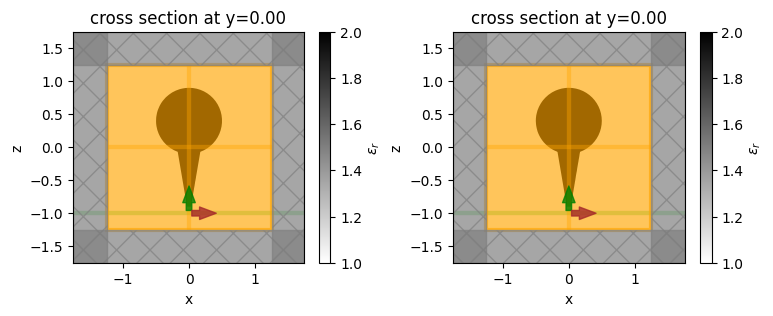

In [11]:
# import the unionized sphere-cone STL
obj_union = td.TriangleMesh.from_stl(
    filename="./misc/icecream_unionized.stl",
    origin=(0, 0, 0.4),
)

# import the non-unionized sphere-cone STL
obj_nounion = td.TriangleMesh.from_stl(
    filename="./misc/icecream_nonunionized.stl",
    origin=(0, 0, 0.4),
)

# make two simulation objects, one with the unionized shape and one with the non-union one
sim_union = sim.copy(update={"structures": [td.Structure(geometry=obj_union, medium=medium)]})
sim_nounion = sim.copy(update={"structures": [td.Structure(geometry=obj_nounion, medium=medium)]})

# plot both simulations
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
sim_union.plot_eps(y=0, ax=ax1)
sim_nounion.plot_eps(y=0, ax=ax2)

plt.show();

## Run Simulations
We'll run both simulations to make sure the results match.

In [12]:
sim_data_union = web.run(sim_union, task_name="stl_icecream_union", path="data/stl_icecream_union.hdf5")
sim_data_nounion = web.run(sim_nounion, task_name="stl_icecream_nounion", path="data/stl_icecream_nounion.hdf5")

           INFO: Created task 'stl_icecream_union' with task_id                     ]8;id=958750;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=446636;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           'fdve-6c38ae14-7c74-4b24-b40b-bc9f0980c3f3v1'.                                    

Output()

Output()

[16:30:17] INFO: status = queued                                                    ]8;id=443152;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=920155;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:30:22] INFO: status = preprocess                                                ]8;id=623630;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=411619;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

[16:30:26] INFO: Maximum FlexUnit cost: 0.025. Use 'web.real_cost(task_id)' to get  ]8;id=466480;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=888767;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           the billed FlexUnit cost after a simulation run.                                  

           INFO: starting up solver                                                 ]8;id=804640;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=623727;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: running solver                                                     ]8;id=265844;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=945172;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:30:37] INFO: early shutoff detected, exiting.                                   ]8;id=949587;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=790776;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: status = postprocess                                               ]8;id=34969;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=321710;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:30:42] INFO: status = success                                                   ]8;id=625519;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=809718;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:30:43] INFO: loading SimulationData from data/stl_icecream_union.hdf5           ]8;id=837957;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=653922;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: Auto meshing using wavelength 0.4243 defined from sources.         ]8;id=296646;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=655295;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: Created task 'stl_icecream_nounion' with task_id                   ]8;id=337172;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=896111;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           'fdve-d8308ecb-28c4-4e85-bc98-d08b3da125ebv1'.                                    

Output()

Output()

[16:30:48] INFO: status = queued                                                    ]8;id=272542;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=589567;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:30:54] INFO: status = preprocess                                                ]8;id=379587;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=882174;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

[16:30:58] INFO: Maximum FlexUnit cost: 0.025. Use 'web.real_cost(task_id)' to get  ]8;id=189269;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=191413;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\
           the billed FlexUnit cost after a simulation run.                                  

           INFO: starting up solver                                                 ]8;id=478609;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=318193;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: running solver                                                     ]8;id=9358;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=568731;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:31:09] INFO: early shutoff detected, exiting.                                   ]8;id=428570;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=493132;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: status = postprocess                                               ]8;id=80305;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=931830;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:31:14] INFO: status = success                                                   ]8;id=760016;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=665566;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

Output()

[16:31:15] INFO: loading SimulationData from data/stl_icecream_nounion.hdf5         ]8;id=302332;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=199405;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

           INFO: Auto meshing using wavelength 0.4243 defined from sources.         ]8;id=136173;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py\log.py]8;;\:]8;id=469921;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/log.py#57\57]8;;\

## Visualize and compare
We can take a look at the permittivity monitors again to make sure the permittivity profiles are properly interpreted and averaged by the solver.

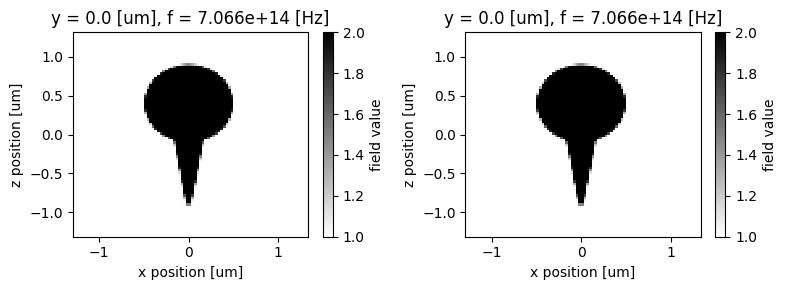

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 3))
sim_data_union["xz_eps"].eps_xx.real.plot(x='x', y='z', ax=ax1, cmap='binary')
sim_data_nounion["xz_eps"].eps_xx.real.plot(x='x', y='z', ax=ax2, cmap='binary')
plt.show();

The permittivity profiles look correct, and as expected, we can see the effect of subpixel averaging at the edges of the shape.

Let's plot the frequency-domain fields for both simulations and make sure they match.

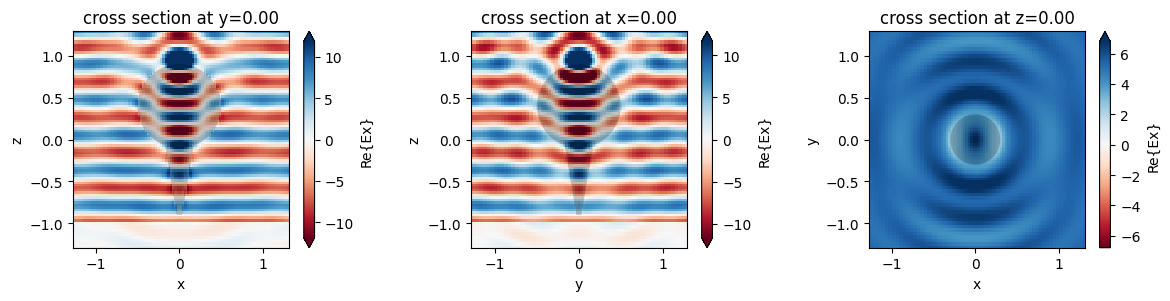

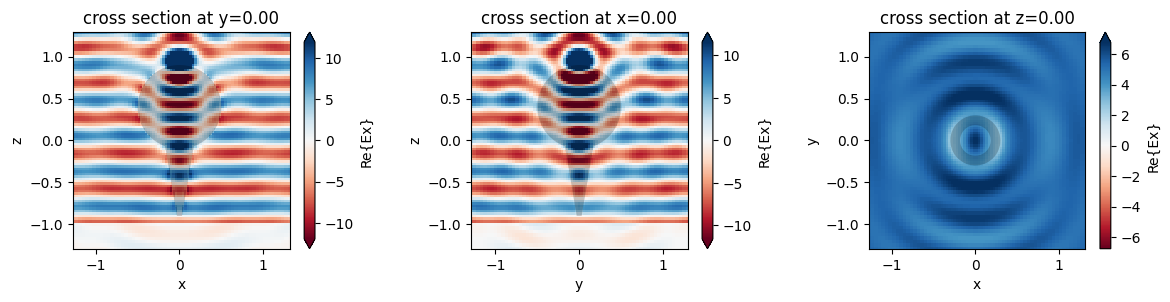

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3))
sim_data_union.plot_field(field_monitor_name="xz", field_name="Ex", val="real", ax=ax1)
sim_data_union.plot_field(field_monitor_name="yz", field_name="Ex", val="real", ax=ax2)
sim_data_union.plot_field(field_monitor_name="xy", field_name="Ex", val="real", ax=ax3)
plt.show()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(12, 3))
sim_data_nounion.plot_field(field_monitor_name="xz", field_name="Ex", val="real", ax=ax1)
sim_data_nounion.plot_field(field_monitor_name="yz", field_name="Ex", val="real", ax=ax2)
sim_data_nounion.plot_field(field_monitor_name="xy", field_name="Ex", val="real", ax=ax3)
plt.show();


The fields match extremely well for both meshes. Although the solver works correctly for both the unionized and non-unionized case, **the safest approach is to ensure all touching objects are unionized prior to exporting the STL.**